## Importing Libraries

In [1]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import matplotlib.pyplot as plt

In [2]:
import cv2 #Used to resize images
import numpy as np
import os
from random import shuffle
from tqdm import tqdm #This is a professional progressbar library
from sklearn.metrics import confusion_matrix
import itertools

## Data Preprocessing

In [3]:
data_dir = './logs/'
train_data_dir = './data/train/'
test_data_dir = './data/test/'

#img_width, img_height = 800, 240
img_width, img_height = 150, 50 #width and height to reduce the size of the image to

learning_rate = 0.001
model_name = "boats_classifier-{}-{}".format(str(learning_rate)+"LR", "4conv-GrayScale") #Descriptive name to save the model

In [4]:
classes = [f.name for f in os.scandir(train_data_dir) if f.is_dir()]
print(classes)

['Mototopo', 'Patanella', 'VaporettoACTV']


In [5]:
def one_hot_label(lbl_class):
  if lbl_class == "Mototopo":
    return [1, 0, 0]
  elif lbl_class == "Patanella":
    return [0, 1, 0]
  elif lbl_class == "VaporettoACTV":
    return [0, 0, 1]

### Preparing Training Data

In [6]:
ytrain = []
train_data = []
Xtrain = []

for root, dirs, files in tqdm(os.walk(train_data_dir)):
  for file in files:
    yclass = root.split("/")[-1]
    img = cv2.resize(cv2.imread(os.path.join(root,file), cv2.IMREAD_GRAYSCALE), (img_width, img_height)) #read image and resize it
    
    label = one_hot_label(root.split("/")[-1])
    Xtrain.append(np.array(img))
    ytrain.append(np.array(label))
    train_data.append([np.array(img), np.array(label)])
    
shuffle(train_data)
np.save(data_dir+"train_data.npy", train_data)


4it [00:07,  1.87s/it]


In [7]:
len(Xtrain)
Xtrain[0].shape
#train_data[3][1]
# temp = train_data[:-50]
# temp2 = train_data[-50:]

(50, 150)

### Preparing Labeled Test Data

In [8]:
ytest = []
Xtest = []
test_data = []

for root, dirs, files in tqdm(os.walk(test_data_dir)):
  for file in files:
    yclass = root.split("/")[-1]
    img = cv2.resize(cv2.imread(os.path.join(root,file), cv2.IMREAD_GRAYSCALE), (img_width, img_height)) #read image and resize it
    
    label = one_hot_label(root.split("/")[-1])
    test_data.append([np.array(img), np.array(label)])
    Xtest.append(np.array(img))
    ytest.append(np.array(label))
    
np.save(data_dir+"test_data.npy", test_data)


4it [00:01,  1.89it/s]


In [9]:
len(Xtest)

683

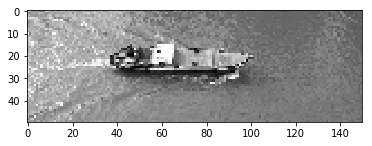

In [10]:
plt.imshow(Xtrain[34], cmap="gray")
plt.show()

## The Network

In [11]:
convnet = input_data(shape=[None, img_width, img_height, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 3, activation='softmax') #we're trying to predict three classes
convnet = regression(convnet, optimizer='adam', learning_rate=learning_rate, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir=data_dir)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
Xtrain = np.array([data for data in Xtrain]).reshape(-1, img_width, img_height, 1)
Xtest = np.array([data for data in Xtest]).reshape(-1, img_width, img_height, 1)

In [13]:
print(Xtrain.shape)
print(len(ytrain))
print(Xtest.shape)
print(len(ytest))

Xtrain[0].shape

(2106, 150, 50, 1)
2106
(683, 150, 50, 1)
683


(150, 50, 1)

## Training the Model

In [14]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print("Using a pre-saved model")
else:
    print("Training a new model")
    model.fit({'input': Xtrain}, {'targets': ytrain}, n_epoch=10, validation_set=({'input': Xtest}, {'targets': ytest}), 
        snapshot_step=50, show_metric=True, run_id=model_name)
    model.save(model_name)
    print("Trained model saved for later use")

Training Step: 329  | total loss: 13.48567 | time: 49.556s
| Adam | epoch: 010 | loss: 13.48567 - acc: 0.4143 -- iter: 2048/2106
Training Step: 330  | total loss: 13.46829 | time: 54.089s
| Adam | epoch: 010 | loss: 13.46829 - acc: 0.4151 | val_loss: 13.45141 - val_acc: 0.4158 -- iter: 2106/2106
--
INFO:tensorflow:/home/sayomakinwa/dev/ml/boats/boats_classifier-0.001LR-4conv-GrayScale is not in all_model_checkpoint_paths. Manually adding it.
Trained model saved for later use


In [15]:
#tensorboard --logdir='./logs/'

## Some Predictions

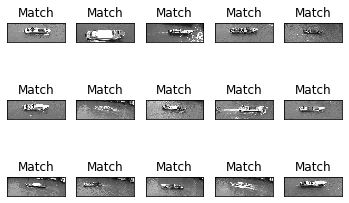

In [16]:
fig = plt.figure()
actual_labels = []
predicted_labels = []
k = 0

for idx, data in enumerate(test_data):
    #Mototopo: [1, 0, 0]
    #Patanella: [0, 1, 0]
    #VaporettoACTV: [0, 0, 1]
    
    img_data = data[0]
    class_num = data[1]
    
    data_for_pred = img_data.reshape(img_width, img_height, 1)
    model_output = model.predict([data_for_pred])[0]
    
    #Limiting this to output just 15 images
    if (k < 15):
        subplot = fig.add_subplot(3, 5, idx+1)
        if np.argmax(model_output) == 0 and class_num[0]: text = "Match"
        elif np.argmax(model_output) == 1 and class_num[1]: text = "Match"
        elif np.argmax(model_output) == 2 and class_num[2]: text = "Match"
        else: text = "Wrong"
        subplot.imshow(img_data, cmap='gray')
        plt.title(text)
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
        k += 1
    #Ends here
        
    #for confusion matrix computation
    actual_labels.append(classes[np.argmax(class_num)])
    predicted_labels.append(classes[np.argmax(model_output)])
    
plt.show()


## Understanding Results and Predictions with Confusion Matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[284   0   0]
 [ 74   0   0]
 [325   0   0]]
Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


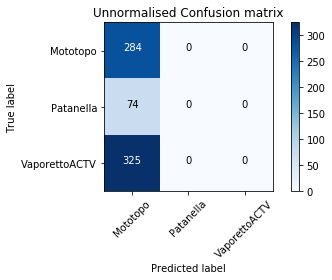

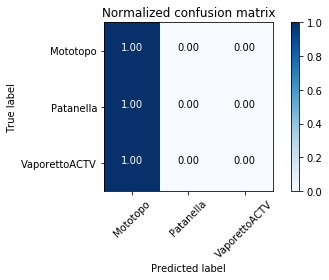

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Unnormalised Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()